<a href="https://colab.research.google.com/github/paper-dragonfly/TulaBlue-Labeling-Tool/blob/main/TulaBlue_Disney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tula Blue Label Assistant**

Three ways to run this tool:<br/>
1. Use the "Runtime" > "Run all" from the navigation bar at the top of the page. Execution will pause at the #UPLOAD CSV until you choose a file then continue through the end
2. Run the cells manually by clicking the play button in the top left of each cell. This may be preferable if you only want to run part of the tool.
3. Click through the cells using 'Shift+Enter'. This will play each cell and jump to the next cell. 

### 1. Genenerate an Acuity schedule CSV
Download a csv of the schedule you would like to evaluate. Make sure to save it in a location that will be easy to find. 
<br/> 
Note: When downloading the CSV, on the 'export to spreadsheet' page, make sure to select the 'health screening questions'option.  

### 2. Upload Acuity Schedule as CSV
To upload your schedule, run the cell bellow by clicking the play icon on the top-left of the cell between the square brackets '[ ]' <br>
Click the 'Choose Files' button and select a file to upload <br>
Wait until the file is 100% uploaded <br><br>
The file should be a schedule downloaded from Acuity in CSV format. The file should contain client intake information that will allow this program to identify individuals requiring further labeling


In [35]:
# UPLOAD CSV
from google.colab import files
uploaded = files.upload()

Saving tula_test.csv to tula_test.csv


### 3. Run Script Code
Run the cell below. 

In [36]:
import pandas as pd
import io

csv_filename = list(uploaded.keys())[0]
df_schedule = pd.read_csv(io.BytesIO(uploaded[csv_filename]))

def flag_clients(file_df):
  flagged = {'first_name': [], 'last_name': [], 'details':[]}
  for index, row in file_df.iterrows():
      flag = False
      condition_details = ""
      injury_or_surgery = row['Have you, in the last year, had an injury or surgery?']
      cleared = row['If yes, have you been cleared by your doctor to receive massage therapy? ']
      health_condition = row['Do you have any current health condition(s) of which we should be aware?']
      what_condition = row['If yes, please describe your current health condition(s) below.']
      check_box_condition = row['Check all that apply. Do you have or suffer from:']

      ## Include patients with recent surgeries/injuries who ARE cleared by doctor to receive massage therapy? 
      ## NO
      # if injury_or_surgery =='yes' and cleared =='no':
      #   flag = True
      #   condition_details = 'Recent injury or surgery, NOT cleared by doctor to receive massage therapy'
      
      ## YES
      if injury_or_surgery == 'yes':
        flag = True
        condition_details += 'Recent injury or surgery '
        if cleared == 'no':
            condition_details += 'NOT cleared by doctor. '
        else:
          condition_details += 'Cleared by doctor. '
        
      if health_condition == 'yes':
          flag = True
          condition_details += f'Health condition: {what_condition}. '
      if check_box_condition != 'I do NOT have or suffer from any of the above conditions.':
          flag = True
          condition_details += f'Checkbox condition(s): {check_box_condition}'
      if flag:
          flagged['first_name'].append(row['First Name'])
          flagged['last_name'].append(row['Last Name'])
          flagged['details'].append(condition_details)
  return flagged

flagged_clients = flag_clients(df_schedule)

df_flagged_clients = pd.DataFrame(flagged_clients)
col_heads = ['First Name', 'Last Name', 'Condition Details']
df_flagged_clients.columns = col_heads

## 4. Generate Flagged Clients List


Clients who indicated on their intake form a condition the therapis shouold be aware of

In [37]:
df_flagged_clients

,First Name,Last Name,Condition Details
0,Peter,Pan,Health condition: lower back pain sciatia .
1,Donald,Duck,Recent injury or surgery Cleared by doctor.
2,Snow,White,"Health condition: Arrythmia, take metoprolol ."
3,Tinker,Bell,Recent injury or surgery Cleared by doctor.
4,Simba,Lionking,Checkbox condition(s): High blood pressure.
5,Mickey,Mouse,Recent injury or surgery Cleared by doctor.


## 5. Export Flagged Clients to PDF
The PDF will appear under the documents tab on the left of the screen with the name 'flagged_{csv_filename}.pdf' where csv_filename is the name of the schedule file you imported above. To download the PDF, hover over the file, click the menu (three vertical dots) and select 'Download'. 

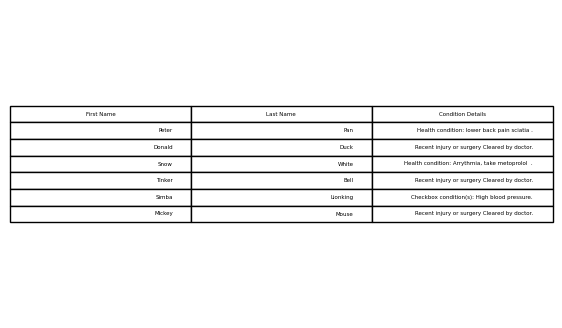

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = df_flagged_clients
num_rows = df.shape[0]

fig, ax =plt.subplots(figsize=(num_rows+1,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')


pp = PdfPages(f"flagged_{csv_filename}.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()


## 6. View Schedule Statistics

In [41]:
import pandas as pd
import io

csv_filename = list(uploaded.keys())[0]
df  = pd.read_csv(io.BytesIO(uploaded[csv_filename]))

num_clients = df.shape[0]
service_types = {}
for index, row in df.iterrows():
  if not row['Type'] in service_types:
    service_types[row['Type']] = 1
  else:
    service_types[row['Type']] += 1

print(f'Number of clients: {num_clients} \n')

print('Service Type Talley')
for key, val in service_types.items():
  print(key, ':',val)
# print(service_types) 

massage_types = {}

for index, row in df.iterrows():
  mt = row['Please select which type of massage you want to receive:']
  if not mt in massage_types:
    massage_types[mt] = 1
  else:
    massage_types[mt] += 1

print('\nMassage Type Talley')
for key, val in massage_types.items():
  print(key,':', val)


percent_labeled = round(df_flagged_clients.shape[0]/num_clients*100)
print(f"\nPercent of clients requiring labeling: {percent_labeled}%")

Number of clients: 46 

Service Type Talley
Disney Health Awareness Week : 46

Massage Type Talley
Upper Back/Neck/Shoulder : 24
Full Back Chair Massage : 19
Low Back/Hip/Leg : 3

Percent of clients requiring labeling: 13%
